In [137]:
import math

import numpy as np
import pandas as pd
from FS import feature_select, delete_zero_and_var
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, scale, RobustScaler, StandardScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import ceil

In [164]:
# 读取cvs训练数据集
cvs_path = "./data/csv/Q4_data.csv"
df = pd.read_csv(cvs_path, index_col=0).drop("SMILES", axis=1)
raw_path = "./data/csv/Molecular_Descriptor_train.csv"
raw_df = pd.read_csv(raw_path, index_col=0).drop("SMILES", axis=1)
print(df.shape)


(632, 730)


In [177]:
# 数据分割
X = df.drop(['pIC50'], axis=1)
y = df['pIC50']
print(X.shape)
# 特征选择

# # 提取后的总训练集和选择的列Name
# 这里 sum=0多了因为数据更小了

del_df_with_pIC50 = delete_zero_and_var(df, 0.0) #带pIC50 用来计算相关度
del_df = delete_zero_and_var(X,0.0) #不带pIC50

corrmat = del_df_with_pIC50.corr()
k = 100  # 关系矩阵中将显示10个特征
corr_sel = corrmat.nlargest(k, 'pIC50')['pIC50'].index
print(corr_sel)

q1_select = ['MDEC-23', 'MLogP', 'LipoaffinityIndex', 'maxsOH', 'nC', 'nT6Ring',
 'minsssN', 'BCUTp-1h', 'C2SP2', 'AMR', 'WPOL', 'SP-5', 'CrippenLogP',
 'MDEC-22', 'nBonds2', 'Zagreb', 'ATSp4', 'VAdjMat', 'ATSc3',
 'ETA_Alpha']

l1 = q1_select + list(corr_sel)[1:]
Q4_final_select = sorted(set(l1),key=l1.index)[:20]

print("fianl",Q4_final_select)
print(len(Q4_final_select))


(632, 729)
最终剩余特征数 492
sum=0特征:  238 方差过小特征:  0
['nB', 'nP', 'nBondsQ', 'nHsNH3p', 'nHssNH2p', 'nHsssNHp', 'nHmisc', 'nsLi', 'nssBe', 'nssssBem', 'nsBH2', 'nssBH', 'nsssB', 'nssssBm', 'nddC', 'nsNH3p', 'nssNH2p', 'nsssNHp', 'nddsN', 'nssssNp', 'naOm', 'nsSiH3', 'nssSiH2', 'nsssSiH', 'nssssSi', 'nsPH2', 'nssPH', 'nsssP', 'ndsssP', 'nddsP', 'nsssssP', 'ndssS', 'nssssssS', 'nSm', 'nsGeH3', 'nssGeH2', 'nsssGeH', 'nssssGe', 'nsAsH2', 'nssAsH', 'nsssAs', 'ndsssAs', 'nddsAs', 'nsssssAs', 'nsSeH', 'ndSe', 'nssSe', 'naaSe', 'ndssSe', 'nssssssSe', 'nddssSe', 'nsSnH3', 'nssSnH2', 'nsssSnH', 'nssssSn', 'nsPbH3', 'nssPbH2', 'nsssPbH', 'nssssPb', 'SHsNH3p', 'SHssNH2p', 'SHsssNHp', 'SHmisc', 'SsLi', 'SssBe', 'SssssBem', 'SsBH2', 'SssBH', 'SsssB', 'SssssBm', 'SddC', 'SsNH3p', 'SssNH2p', 'SsssNHp', 'SddsN', 'SssssNp', 'SaOm', 'SsSiH3', 'SssSiH2', 'SsssSiH', 'SssssSi', 'SsPH2', 'SssPH', 'SsssP', 'SdsssP', 'SddsP', 'SsssssP', 'SdssS', 'SssssssS', 'SSm', 'SsGeH3', 'SssGeH2', 'SsssGeH', 'SssssGe', 'SsAsH2'

In [178]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

# Setup cross validation folds
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=6,
                         learning_rate=0.01,
                         n_estimators=7000,
                         max_bin=200,
                         bagging_fraction=0.8,
                         bagging_freq=4,
                         bagging_seed=8,
                         feature_fraction=0.2,
                         feature_fraction_seed=8,
                         min_sum_hessian_in_leaf=11,
                         verbose=-1,
                         random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C=100, epsilon=0.008, gamma=0.003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=3000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=800,
                           max_depth=15,
                           min_samples_split=5,
                           min_samples_leaf=5,
                           max_features=None,
                           oob_score=True,
                           random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [179]:
print(del_df.shape)

(632, 491)


In [180]:

# Define error metrics
def mse(y, y_pred):
    return mean_squared_error(y, y_pred)


def mae(y, y_pred):
    return mean_absolute_error(y, y_pred)


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def cv_rmse(model, X=X, y=y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [181]:
del_df = del_df[Q4_final_select]
X_train = del_df
y_train = y

print(X_train.shape)
print(y.shape)

(632, 20)
(632,)


In [182]:
# 开始训练模型
print('stack_gen done')
stack_gen_model = stack_gen.fit(X_train, y_train)
print('lightgbm done')
lgb_model_full_data = lightgbm.fit(X_train, y_train)
print('xgboost done')
xgb_model_full_data = xgboost.fit(X_train, y_train)
print('Svr done')
svr_model_full_data = svr.fit(X_train, y_train)
print('RandomForest done')
rf_model_full_data = rf.fit(X_train, y_train)
print('GradientBoosting done')
gbr_model_full_data = gbr.fit(X_train, y_train)
print("all done")

stack_gen done
[01:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current valu

In [183]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return (
            (0.05 * svr_model_full_data.predict(X)) +
            (0.1 * gbr_model_full_data.predict(X)) +
            (0.1 * xgb_model_full_data.predict(X)) +
            (0.35 * lgb_model_full_data.predict(X)) +
            (0.05 * rf_model_full_data.predict(X)) +
            (0.40 * stack_gen_model.predict(X)))

In [184]:
# Get final precitions from the blended model
y_perd = blended_predictions(X_train)
blended_score = mse(y_train, y_perd)
print('MSE score on train data:', blended_score)
print('RMSLE score on train data:', rmsle(y_train, y_perd))
print('MAE score on train data:', mae(y_train, y_perd))


MSE score on train data: 0.20069801796609224
RMSLE score on train data: 0.44799332357312227
MAE score on train data: 0.36907415223313134


In [185]:


def objective(X):
    ret = blended_predictions(np.expand_dims(X, axis=0))
    return -ret[0]


def max_objective(**kwargs):
    X = np.fromiter(kwargs.values(), dtype=float)
    print(X)
    ret = blended_predictions(np.expand_dims(X, axis=0))
    return ret[0]

In [226]:
from hyperopt import hp, tpe, Trials, fmin, anneal, STATUS_OK

# space2 = [hp.uniform('MDEC-23', 0, 55),
#          hp.uniform('MLogP', 1, 6),
#          hp.uniform('LipoaffinityIndex', -5, 25),
#          hp.uniform('maxsOH', 0, 13),
#          hp.uniform('nC', 5, 100),
#          hp.uniform('nT6Ring', 0, 10),
#          hp.uniform('minsssN', 0, 3),
#          hp.uniform('BCUTp-1h', 5, 20),
#          hp.uniform('C2SP2', 0, 25),
#          hp.uniform('AMR', 54, 520),
#          hp.uniform('WPOL', 14, 250),
#          hp.uniform('SP-5', 1, 30),
#          hp.uniform('CrippenLogP', -15, 12),
#          hp.uniform('MDEC-22', 0, 35),
#          hp.uniform('nBonds2', 22, 343),
#          hp.uniform('Zagreb', 62, 750),
#          hp.uniform('ATSp4', 700, 20000),
#          hp.uniform('VAdjMat', 0, 10),
#          hp.uniform('ATSc3', -1, 1),
#          hp.uniform('ETA_Alpha', 5, 75)]
# 优化函数

space = []

raw_df_e = raw_df[Q4_final_select]
s_max = raw_df_e.max()
s_min = raw_df_e.min()
index = list(del_df)

for i in index:
    sc = int(abs(s_min[i] - s_max[i])/10)
    print(i, s_min[i], s_max[i],sc)
    space.append(hp.uniform(i, s_min[i],s_max[i]))

print(space)

MDEC-23 0.0 54.0201510618835 5
MLogP 1.46 5.75 0
LipoaffinityIndex -4.58887987602517 23.0036813723651 2
maxsOH 0.0 12.470850049922 1
nC 7.0 95.0 8
nT6Ring 0.0 7.0 0
minsssN 0.0 2.73477211777987 0
BCUTp-1h 7.96939897605524 16.7482907932269 0
C2SP2 0.0 24.0 2
AMR 54.067 517.4294 46
WPOL 14.0 230.0 21
SP-5 1.85134064774192 27.2258699213241 2
CrippenLogP -13.2664499999999 12.0701799999999 2
MDEC-22 0.0 35.3207053361756 3
nBonds2 22.0 343.0 32
Zagreb 62.0 748.0 68
ATSp4 728.970188498375 17063.0572775008 1633
VAdjMat 4.8073549220576 8.34872815423107 0
ATSc3 -0.372921531317864 0.537745503030608 0
ETA_Alpha 6.49999 74.23326 6
[<hyperopt.pyll.base.Apply object at 0x000002215E87BE50>, <hyperopt.pyll.base.Apply object at 0x000002215EA57A90>, <hyperopt.pyll.base.Apply object at 0x000002215EE4F7F0>, <hyperopt.pyll.base.Apply object at 0x000002215B4F0250>, <hyperopt.pyll.base.Apply object at 0x000002215FC54DC0>, <hyperopt.pyll.base.Apply object at 0x000002215F2AC2B0>, <hyperopt.pyll.base.Apply objec

In [228]:
# space = [hp.uniform('MDEC-23', 0, 55),
#          hp.uniform('MLogP', 1, 6),
#          hp.uniform('LipoaffinityIndex', -5, 25),
#          hp.uniform('maxsOH', 0, 13),
#          hp.uniform('nC', 5, 100),
#          hp.uniform('nT6Ring', 0, 10),
#          hp.uniform('minsssN', 0, 3),
#          hp.uniform('BCUTp-1h', 5, 20),
#          hp.uniform('C2SP2', 0, 25),
#          hp.uniform('AMR', 54, 520),
#          hp.uniform('WPOL', 14, 250),
#          hp.uniform('SP-5', 1, 30),
#          hp.uniform('CrippenLogP', -15, 12),
#          hp.uniform('MDEC-22', 0, 35),
#          hp.uniform('nBonds2', 22, 343),
#          hp.uniform('Zagreb', 62, 750),
#          hp.uniform('ATSp4', 700, 20000),
#          hp.uniform('VAdjMat', 0, 10),
#          hp.uniform('ATSc3', -1, 1),
#          hp.uniform('ETA_Alpha', 5, 75)]

max_evals = 500
tpe_algo = anneal.suggest
# tpe_algo = tpe.suggest
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe_algo, trials=trials,
            max_evals=max_evals)
print(best)
print(trials.results)


100%|██████████| 500/500 [00:56<00:00,  8.87trial/s, best loss: -8.891376192892707]
{'AMR': 225.56204237724455, 'ATSc3': -0.07219604677858472, 'ATSp4': 8672.29266719364, 'BCUTp-1h': 13.002514272349483, 'C2SP2': 18.644711374647045, 'CrippenLogP': 6.546480463993751, 'ETA_Alpha': 58.979853871828, 'LipoaffinityIndex': 16.606284413049927, 'MDEC-22': 23.286016522048996, 'MDEC-23': 33.04702919327439, 'MLogP': 4.209760161453647, 'SP-5': 13.924649631068881, 'VAdjMat': 7.035289449586315, 'WPOL': 66.8096265598032, 'Zagreb': 325.164058795391, 'maxsOH': 4.983348346341054, 'minsssN': 2.45934891137049, 'nBonds2': 180.4822464442379, 'nC': 45.54239502891602, 'nT6Ring': 4.291762705602099}
[{'loss': -7.617849015516352, 'status': 'ok'}, {'loss': -7.142790634228884, 'status': 'ok'}, {'loss': -6.302130959395221, 'status': 'ok'}, {'loss': -6.601856958622601, 'status': 'ok'}, {'loss': -7.182989128164136, 'status': 'ok'}, {'loss': -7.279127287114215, 'status': 'ok'}, {'loss': -6.5410355821877975, 'status': 'ok

In [192]:
loss = []
for t in trials.results:
    loss.append(-(t.get('loss')))
print(loss)

[6.024422306077819, 6.328159909351266, 5.84408174918789, 7.58827499645336, 6.029505142788652, 5.8912031098889805, 6.907762125983322, 6.071392544807736, 6.666996874671203, 6.283315246786616, 5.359025101255867, 5.934265984355969, 6.016519994722044, 7.100215151535656, 7.24381941222202, 7.194787136274087, 5.868713687835491, 7.0129300653085895, 5.741110462577807, 5.933669498788311, 7.452523730465211, 7.483734167439361, 7.14113266737453, 7.63912650582113, 7.103145229819892, 6.888492674803077, 7.830605840804747, 7.912085072235991, 7.55844102325087, 7.96865179501078, 7.569384608791252, 7.162091540643538, 6.859113608492819, 7.397451427653815, 7.203742675685356, 7.473171061059773, 7.241929428264352, 7.314965558863752, 7.790290306308416, 6.813225624160731, 7.349718835111673, 7.488887391087526, 6.990232215503473, 6.869832696766325, 6.743084650177507, 6.263457723654765, 7.525660714309417, 6.703438469311105, 6.641748221554132, 7.092816244606715, 6.9948781305606875, 6.601819211333924, 7.1350806347674

In [ ]:
ax = sns.scatterplot( data=loss)
plt.title('Scatter of hue')
plt.grid()
plt.show()


Text(0, 0.5, 'pIC50')

<Figure size 1800x1200 with 0 Axes>

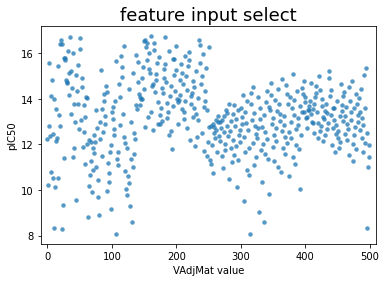

In [225]:
plt.figure(dpi=300)
f, ax = plt.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['BCUTp-1h'] for t in trials.trials]
ax.set_xlim(xs[0] - 10, xs[-1] + 10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('feature input select', fontsize=18)
ax.set_xlabel('VAdjMat value', fontsize=10)
ax.set_ylabel('pIC50', fontsize=10)

In [233]:
from bayes_opt import BayesianOptimization


def max1_objective(**kwargs):
    input_name = ['MDEC-23', 'MLogP', 'LipoaffinityIndex', 'maxsOH', 'nC', 'nT6Ring', 'minsssN', 'BCUTp-1h', 'C2SP2',
                  'AMR', 'WPOL', 'SP-5', 'CrippenLogP', 'MDEC-22', 'nBonds2', 'Zagreb', 'ATSp4', 'VAdjMat', 'ATSc3',
                  'ETA_Alpha']
    X = []
    for i in input_name:
        X.append(kwargs.get(i))
    X = np.fromiter(kwargs.values(), dtype=float)
    # print(X)
    ret = blended_predictions(np.expand_dims(X, axis=0))
    return ret[0]


pbouds = {
    'MDEC-23': (0, 55),
    'MLogP': (1, 6),
    'LipoaffinityIndex': (-5, 25),
    'maxsOH': (0, 13),
    'nC': (5, 100),
    'nT6Ring': (0, 10),
    'minsssN': (0, 3),
    'BCUTp-1h': (5, 20),
    'C2SP2': (0, 25),
    'AMR': (54, 520),
    'WPOL': (14, 250),
    'SP-5': (1, 30),
    'CrippenLogP': (-15, 12),
    'MDEC-22': (0, 35),
    'nBonds2': (22, 343),
    'Zagreb': (62, 750),
    'ATSp4': (700, 20000),
    'VAdjMat': (0, 10),
    'ATSc3': (-1, 1),
    'ETA_Alpha': (5, 75)
}
optimizer = BayesianOptimization(
    f=max1_objective,
    pbounds=pbouds,
    verbose=1,
    random_state=1,
)
optimizer.maximize(
    n_iter=200
)

print(optimizer.max)

|   iter    |  target   |    AMR    |   ATSc3   |   ATSp4   | BCUTp-1h  |   C2SP2   | Crippe... | ETA_Alpha | Lipoaf... |  MDEC-22  |  MDEC-23  |   MLogP   |   SP-5    |  VAdjMat  |   WPOL    |  Zagreb   |  maxsOH   |  minsssN  |  nBonds2  |    nC     |  nT6Ring  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  4        |  6.988    |  101.7    | -0.1719   |  1.41e+04 |  11.21    |  1.249    | -0.5308   |  51.47    |  10.45    |  33.06    |  32.26    |  5.517    |  4.987    |  1.393    |  204.5    |  335.6    |  2.15     |  2.783    |  133.6    |  76.33    |  7.26     |
|  5        |  7.109    |  465.6    |  0.2473   |  1.519e+0 |  10.23    |  6.748    |  9.189    |  34.97    |  23.95    |  23.22    |  34.19    |  1.574    |  28.54    |  4.499    |  150.5    |  342.8  

In [ ]:
# 遗传算法